In [1]:
from triage.component.postmodeling.contrast.model_class import ModelAnalyzer
from triage.component.postmodeling.contrast.report_generator import PostmodelingReport

In [2]:
import pandas as pd
from sqlalchemy import create_engine

### DB Connection

In [3]:
# The connection to the db which has the triage experiment information
engine = create_engine("postgresql:///?service=acdhs_housing")

### Inputs to the report generator

In [4]:
model_groups=[352, 353]
experiment_hash = '13e7d216a2922b2dcae51f2d68242aae'
project_path = 's3://dsapp-social-services-migrated/acdhs_housing/triage_experiments/' 

### Initializing the object

In [5]:
rep = PostmodelingReport(engine, model_groups, experiment_hash)

### TODO -- Summary

We could generate a summary of what models we are comparing, chort sizes, label distributions

## 1. Score distributions

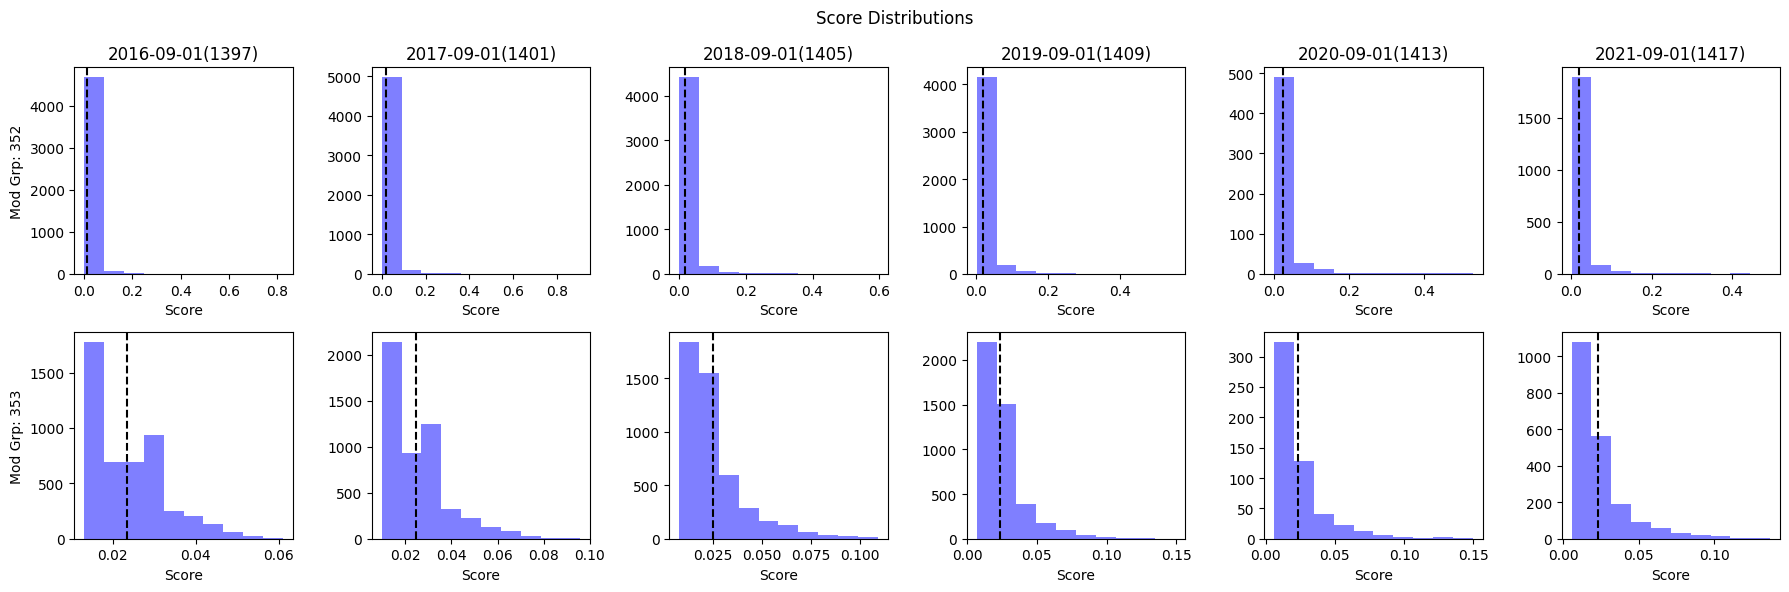

In [6]:
rep.plot_score_distributions()

note to myself -- What's the vertical line? (check the model analyzer class)

### 2. PR-k Curves

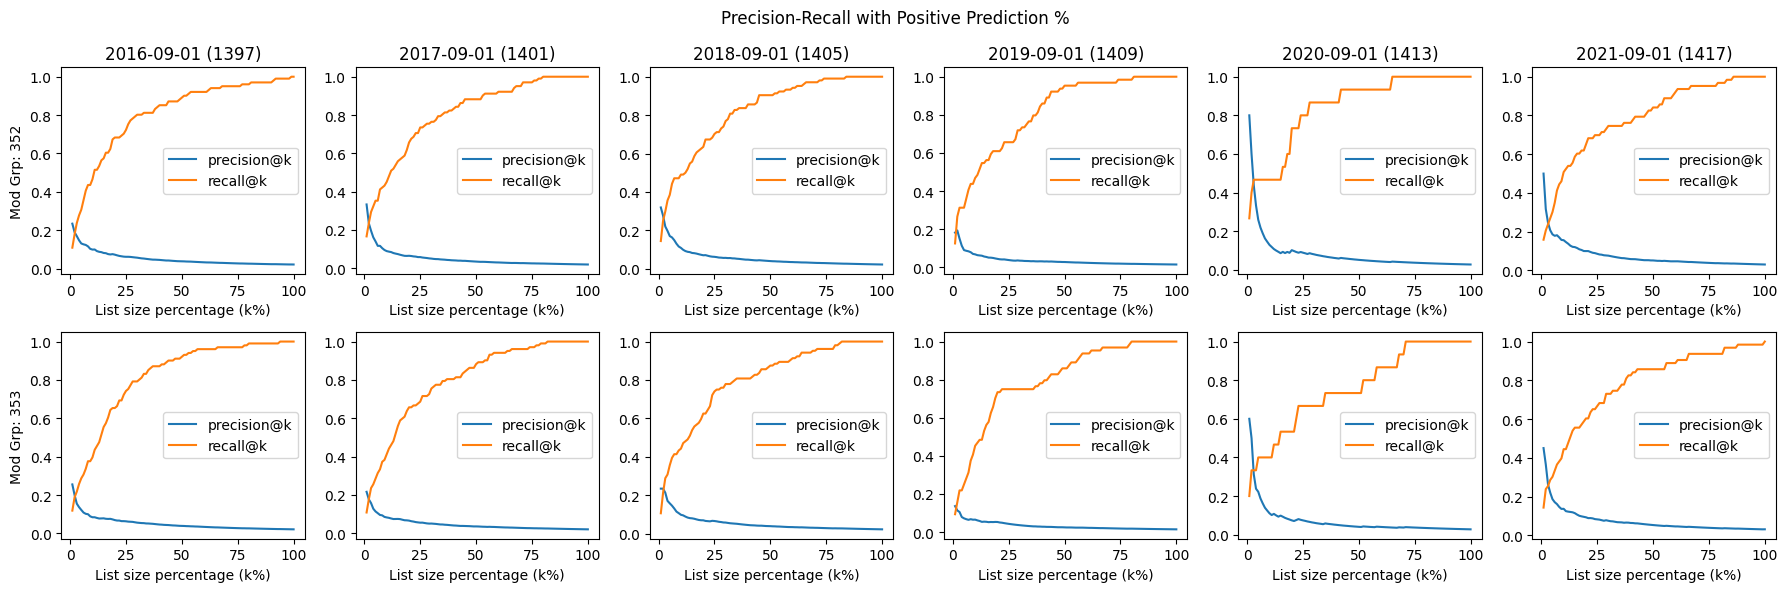

In [7]:
rep.plot_prk_curves()

### 3. Feature Importance

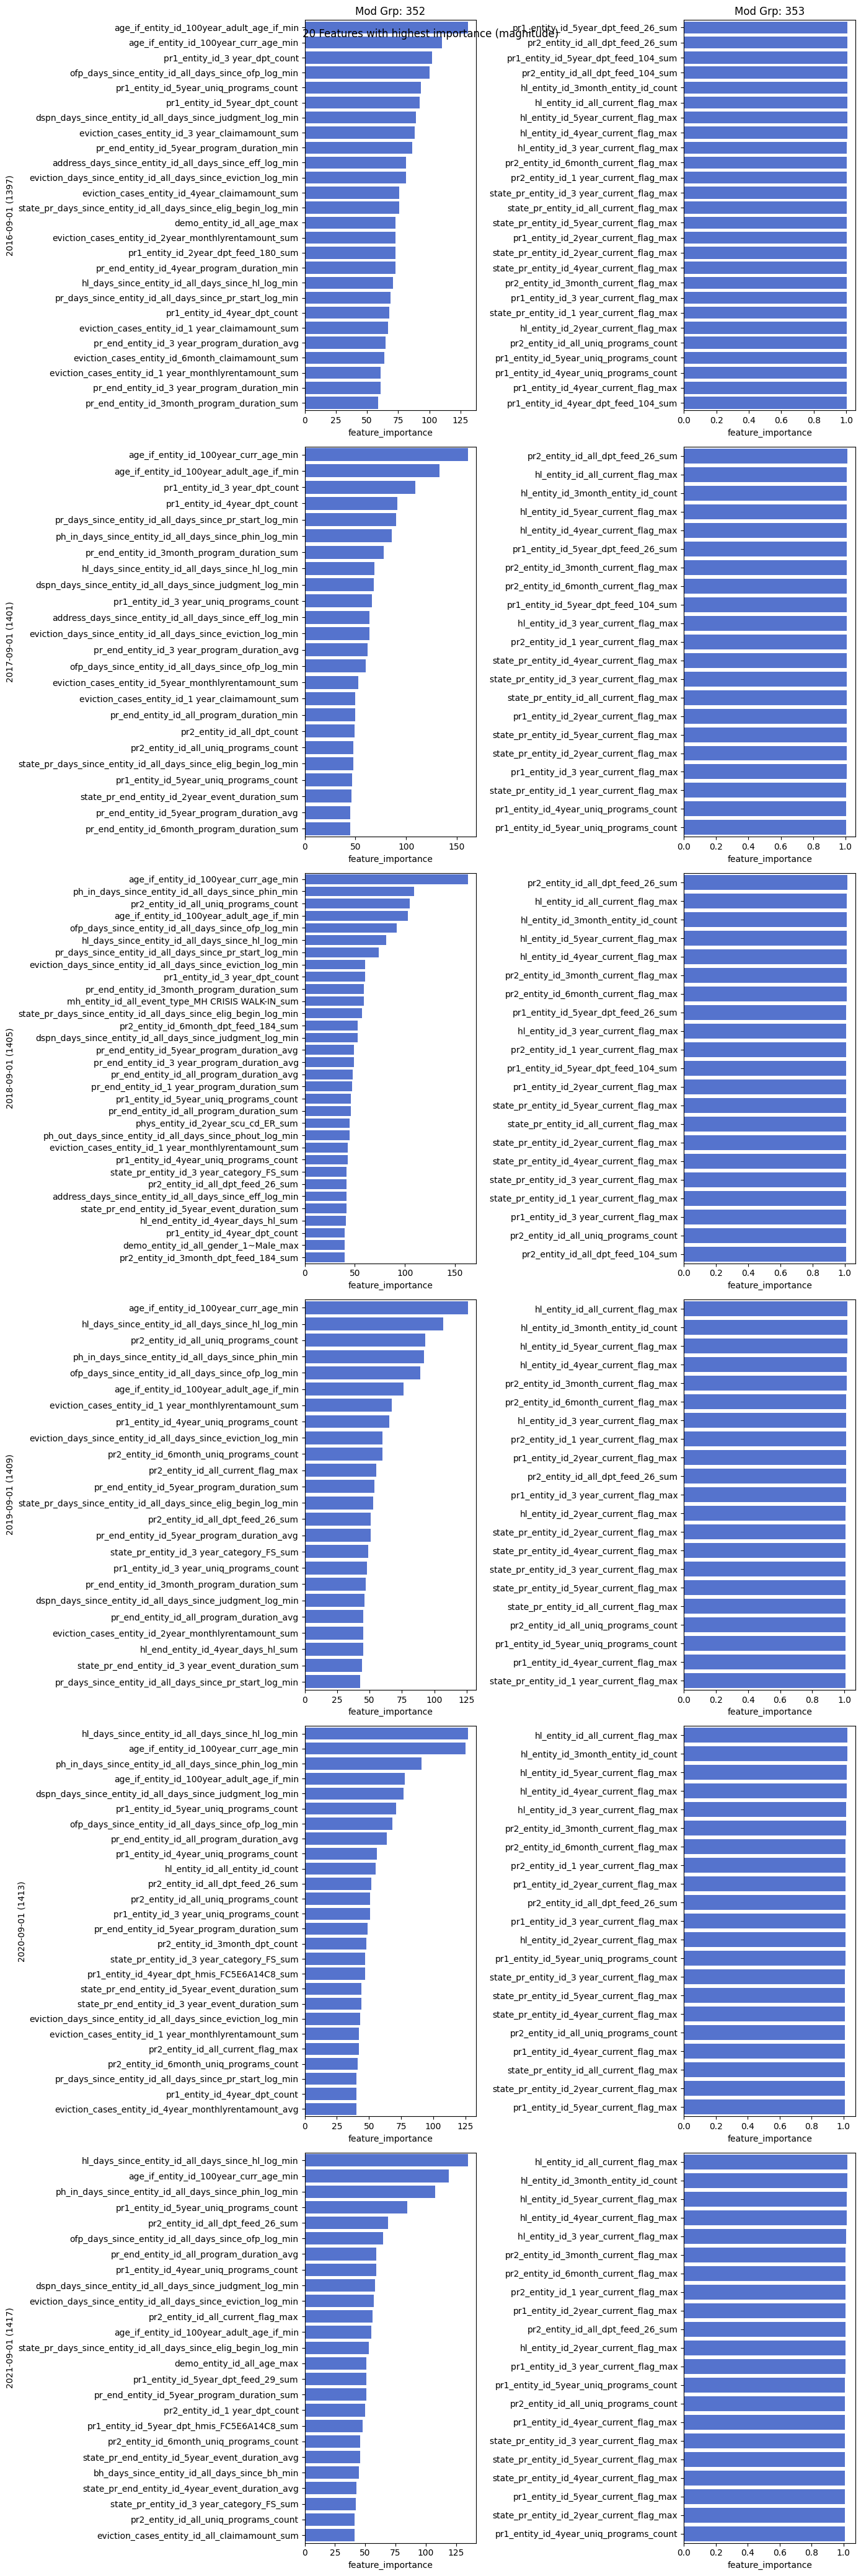

In [8]:
rep.plot_feature_importance()

### 4. Crosstabs

In [10]:
rep.calculate_crosstabs_pos_vs_neg(
    project_path=project_path,
    thresholds={'rank_abs_no_ties': 100},
    table_name='kasun_crosstab_test3',
    return_df=False,
    push_to_db=True,
    replace=False
) 

2023-04-18 19:24:53 - WARNING Crosstabs aleady exist for model 1397
2023-04-18 19:24:53 -    INFO Replace set to False. Not calculating crosstabs for model 1397
2023-04-18 19:24:53 - WARNING Crosstabs aleady exist for model 1401
2023-04-18 19:24:53 -    INFO Replace set to False. Not calculating crosstabs for model 1401
2023-04-18 19:24:54 - WARNING Crosstabs aleady exist for model 1405
2023-04-18 19:24:54 -    INFO Replace set to False. Not calculating crosstabs for model 1405
2023-04-18 19:24:54 - WARNING Crosstabs aleady exist for model 1409
2023-04-18 19:24:54 -    INFO Replace set to False. Not calculating crosstabs for model 1409
2023-04-18 19:24:54 - WARNING Crosstabs aleady exist for model 1413
2023-04-18 19:24:54 -    INFO Replace set to False. Not calculating crosstabs for model 1413
2023-04-18 19:24:54 - WARNING Crosstabs aleady exist for model 1417
2023-04-18 19:24:54 -    INFO Replace set to False. Not calculating crosstabs for model 1417
2023-04-18 19:24:54 - WARNING Cros

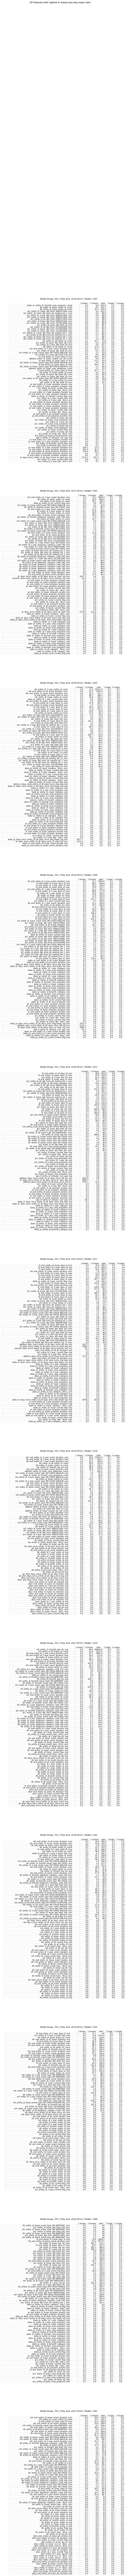

In [12]:
dfs = rep.display_crosstab_pos_vs_neg(
    threshold_type='rank_abs_no_ties',
    threshold=100,
    table_name='kasun_crosstab_test3',
    project_path=project_path,
    display_n_features=40,
    filter_features=None,
    support_threshold=0.2,
    return_dfs=True
)

In [11]:
table_name = "kasun_crosstabs_test"

q = """
    select 
        model_id, feature, metric, value 
    from test_results.kasun_crosstab_test 
    where threshold_type = 'rank_abs_no_ties'
    and threshold = 100
    and 
    metric in (
        'mean_ratio_predicted_positive_to_predicted_negative',
        'support_predicted_positive',
        'support_predicted_negative'
    )
    and model_id = 1533
"""

ct = pd.read_sql(q, engine)

In [140]:
pivot_table = pd.pivot(ct, index='feature', columns='metric', values='value').sort_values('mean_ratio_predicted_positive_to_predicted_negative', ascending = False)

In [141]:
pivot_table.rename(columns={
    'mean_ratio_predicted_positive_to_predicted_negative': 'mean_ratio',
    'support_predicted_negative': 'support_neg',
    'support_predicted_positive': 'support_pos'
}, inplace=True
)
# pivot_table.reset_index(inplace=True)
# pivot_table.index.name=''
pivot_table.columns.name=''

In [142]:
msk = pivot_table['support_pos'] > 20

df = pivot_table[msk].head(10)

In [166]:
import matplotlib.pyplot as plt

import matplotlib.table as tab

import numpy as np

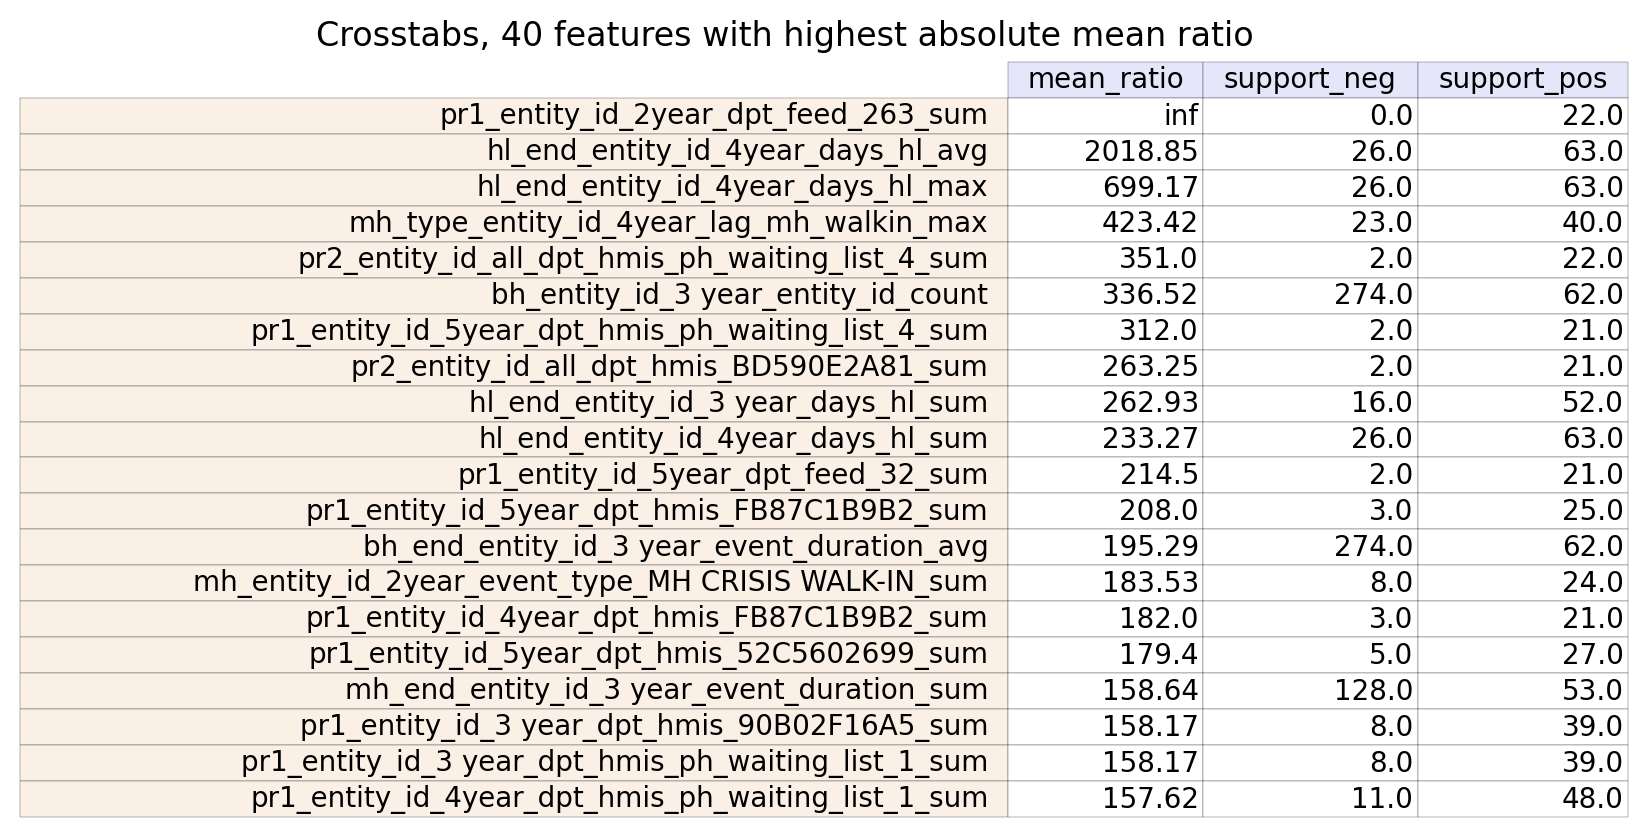

In [174]:
n = 20
df = pivot_table[msk].head(n)

fig, ax = plt.subplots(1, 1, dpi=200, figsize=(4, 1 + n / 5))

# hide axes
# fig.patch.set_visible(False)

# table = ax.table(
#     cellText=df.values.round(2), 
#     colLabels=df.columns, 
#     rowLabels=df.index, 
#     loc='center', 
#     bbox='tight')
# table.scale(1, 2)
# ax.axis('off')

# ax.set_title('Crosstabs, 40 features with highest absolte mean ratio')
# ax.layout('tight')
# plt.show()

rcolors = np.full(len(df.index), 'linen')
ccolors = np.full(len(df.columns), 'lavender')


t = tab.table(
    ax, 
    cellText=df.values.round(2), 
    colLabels=df.columns, 
    rowLoc='right',
    rowLabels=df.index, 
    colColours=ccolors,
    rowColours=rcolors,
    bbox=[0, 0, 1, 1]
)

ax.set_title('Crosstabs, 40 features with highest absolute mean ratio', x = -0.1)
ax.axis('off')
t.auto_set_column_width([0, 1, 2])
# t.auto_set_font_size(value=True)
for key, cell in t.get_celld().items():
    cell.set_linewidth(0.1)
    cell.PAD = 0.02
#     cell.set_fontsize(11)

In [67]:
!pip show matplotlib

Name: matplotlib
Version: 3.5.1
Summary: Python plotting package
Home-page: https://matplotlib.org
Author: John D. Hunter, Michael Droettboom
Author-email: matplotlib-users@python.org
License: PSF
Location: /home/kasun/.pyenv/versions/3.8.2/envs/triage-3.8.2/lib/python3.8/site-packages
Requires: cycler, fonttools, kiwisolver, numpy, packaging, pillow, pyparsing, python-dateutil
Required-by: adjustText, aequitas, seaborn, triage
